In [1]:
# Clone the CKAN repository into Kaggle's writable working directory
!git clone https://github.com/AntonioTepsich/ckan.git /kaggle/working/Convolutional-KANs

# Change the current working directory to the cloned repository
%cd /kaggle/working/Convolutional-KANs

Cloning into '/kaggle/working/Convolutional-KANs'...
remote: Enumerating objects: 2379, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 2379 (delta 266), reused 311 (delta 196), pack-reused 1970 (from 1)
Receiving objects: 100% (2379/2379), 45.65 MiB | 36.43 MiB/s, done.
Resolving deltas: 100% (1286/1286), done.
/kaggle/working/Convolutional-KANs


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, random_split
from kan_convolutional.KANConv import KAN_Convolutional_Layer
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
class KANC_MLP(nn.Module):
    def __init__(self, grid_size: int = 10):
        super().__init__()
        
        # First KAN convolutional layer: 1 input channel to 16 output channels
        self.conv1 = KAN_Convolutional_Layer(
            in_channels=1,
            out_channels=16,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        
        # Second KAN convolutional layer: 16 input channels to 16 output channels
        self.conv2 = KAN_Convolutional_Layer(
            in_channels=16,
            out_channels=16,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        
        # Third KAN convolutional layer: 16 input channels to 16 output channels
        self.conv3 = KAN_Convolutional_Layer(
            in_channels=16,
            out_channels=16,
            kernel_size=(3,3),
            grid_size=grid_size
        )
        
        # Max pooling layer to reduce spatial dimensions
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Flatten layer
        self.flat = nn.Flatten()
        
        # Fully connected layer: Adjusted for new feature map size
        # Input: 28x28 → conv1 (26x26) → pool (13x13) → conv2 (11x11) → pool (5x5) → conv3 (3x3) → 3x3x16 = 144
        self.linear1 = nn.Linear(144, 10)
        
        self.name = f"KANC MLP (Big) (gs = {grid_size})"

    def forward(self, x):
        x = self.conv1(x)      # 28x28x1 → 26x26x16
        x = self.pool(x)       # 26x26x16 → 13x13x16
        x = self.conv2(x)      # 13x13x16 → 11x11x16
        x = self.pool(x)       # 11x11x16 → 5x5x16
        x = self.conv3(x)      # 5x5x16 → 3x3x16
        x = self.flat(x)       # 3x3x16 → 144
        x = self.linear1(x)    # 144 → 10
        x = F.log_softmax(x, dim=1)
        return x

In [4]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_dataset = FashionMNIST(root='/kaggle/working/data', train=True, download=True, transform=train_transform)
test_dataset = FashionMNIST(root='/kaggle/working/data', train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.2MB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.95MB/s]


Extracting /kaggle/working/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 13.0MB/s]

Extracting /kaggle/working/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/FashionMNIST/raw



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KANC_MLP(grid_size=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
print(f"Using device: {device}")

Using device: cuda


In [6]:
epochs = 10
train_losses = []
val_losses = []
val_accuracies = []
learning_rates = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, LR: {current_lr:.6f}")

Epoch [1/10]
Train Loss: 0.7020, Val Loss: 0.5255, Val Accuracy: 80.67%, LR: 0.001000
Epoch [2/10]
Train Loss: 0.5070, Val Loss: 0.4578, Val Accuracy: 83.22%, LR: 0.001000
Epoch [3/10]
Train Loss: 0.4569, Val Loss: 0.4339, Val Accuracy: 84.16%, LR: 0.001000
Epoch [4/10]
Train Loss: 0.4371, Val Loss: 0.4222, Val Accuracy: 84.33%, LR: 0.001000
Epoch [5/10]
Train Loss: 0.4175, Val Loss: 0.4091, Val Accuracy: 85.01%, LR: 0.001000
Epoch [6/10]
Train Loss: 0.4021, Val Loss: 0.4013, Val Accuracy: 85.26%, LR: 0.001000
Epoch [7/10]
Train Loss: 0.3991, Val Loss: 0.4079, Val Accuracy: 85.03%, LR: 0.001000
Epoch [8/10]
Train Loss: 0.3902, Val Loss: 0.3927, Val Accuracy: 85.48%, LR: 0.001000
Epoch [9/10]
Train Loss: 0.3861, Val Loss: 0.3794, Val Accuracy: 86.03%, LR: 0.001000
Epoch [10/10]
Train Loss: 0.3780, Val Loss: 0.3676, Val Accuracy: 86.80%, LR: 0.001000



Test set:
Accuracy: 87.66%
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


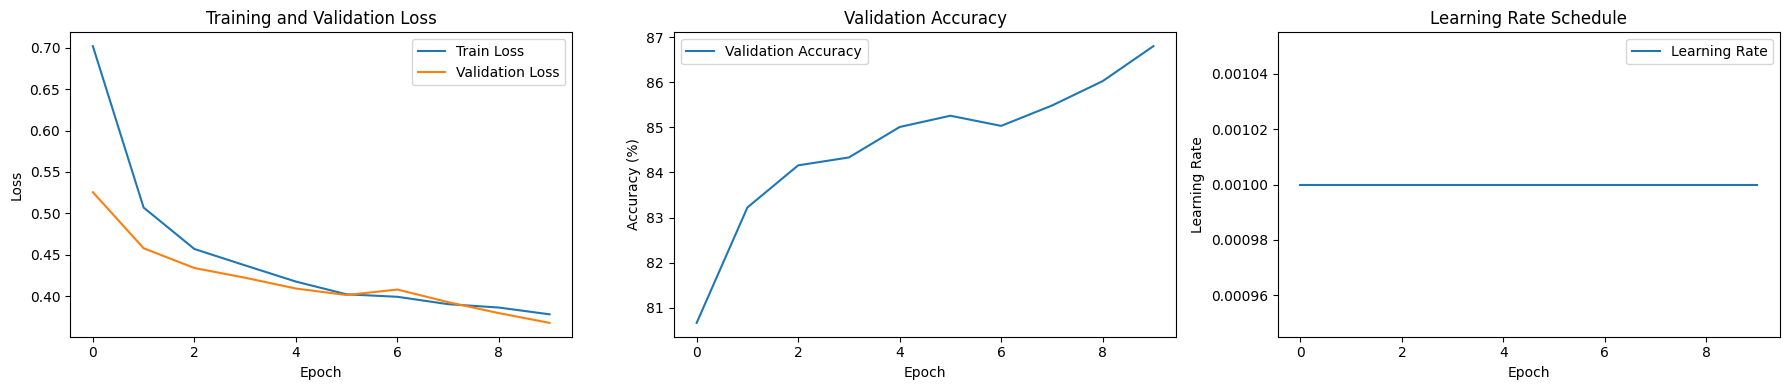

In [7]:
model.eval()
test_loss = 0
correct = 0
all_targets = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (labels == predicted).sum().item()
        all_targets.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / len(test_loader.dataset)
precision = precision_score(all_targets, all_predictions, average='macro')
recall = recall_score(all_targets, all_predictions, average='macro')
f1 = f1_score(all_targets, all_predictions, average='macro')

print('\nTest set:')
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy')
plt.subplot(1, 3, 3)
plt.plot(learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule')
plt.tight_layout()
plt.show()